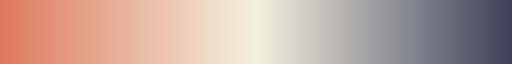

In [1]:
from scipy import odr
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as mcolors
import plotly.express as px, plotly.graph_objects as go
import os
import seaborn as sns
from matplotlib.colors import to_rgba

pd.options.mode.chained_assignment = None

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  

# Define a custom color palette (e.g., from red to yellow to green)
colors = ["#e07a5f", "#f4f1de", "#3d405b"]  # Red -> Yellow -> Green

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap

# Define Paths where the HRDTimer output is stored

In [5]:
# Need to check the filenames and define a naming convention
OUTPUT_PCAWG = "AA_NEW_TEST_RUN_PCAWG_Apr25_v2"
OUTPUT_SCANB = "AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25"
OUTPUT_INFORM = "AA_NEW_TEST_RUN_INFORM_germline_filtered_v2"

# To remove

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



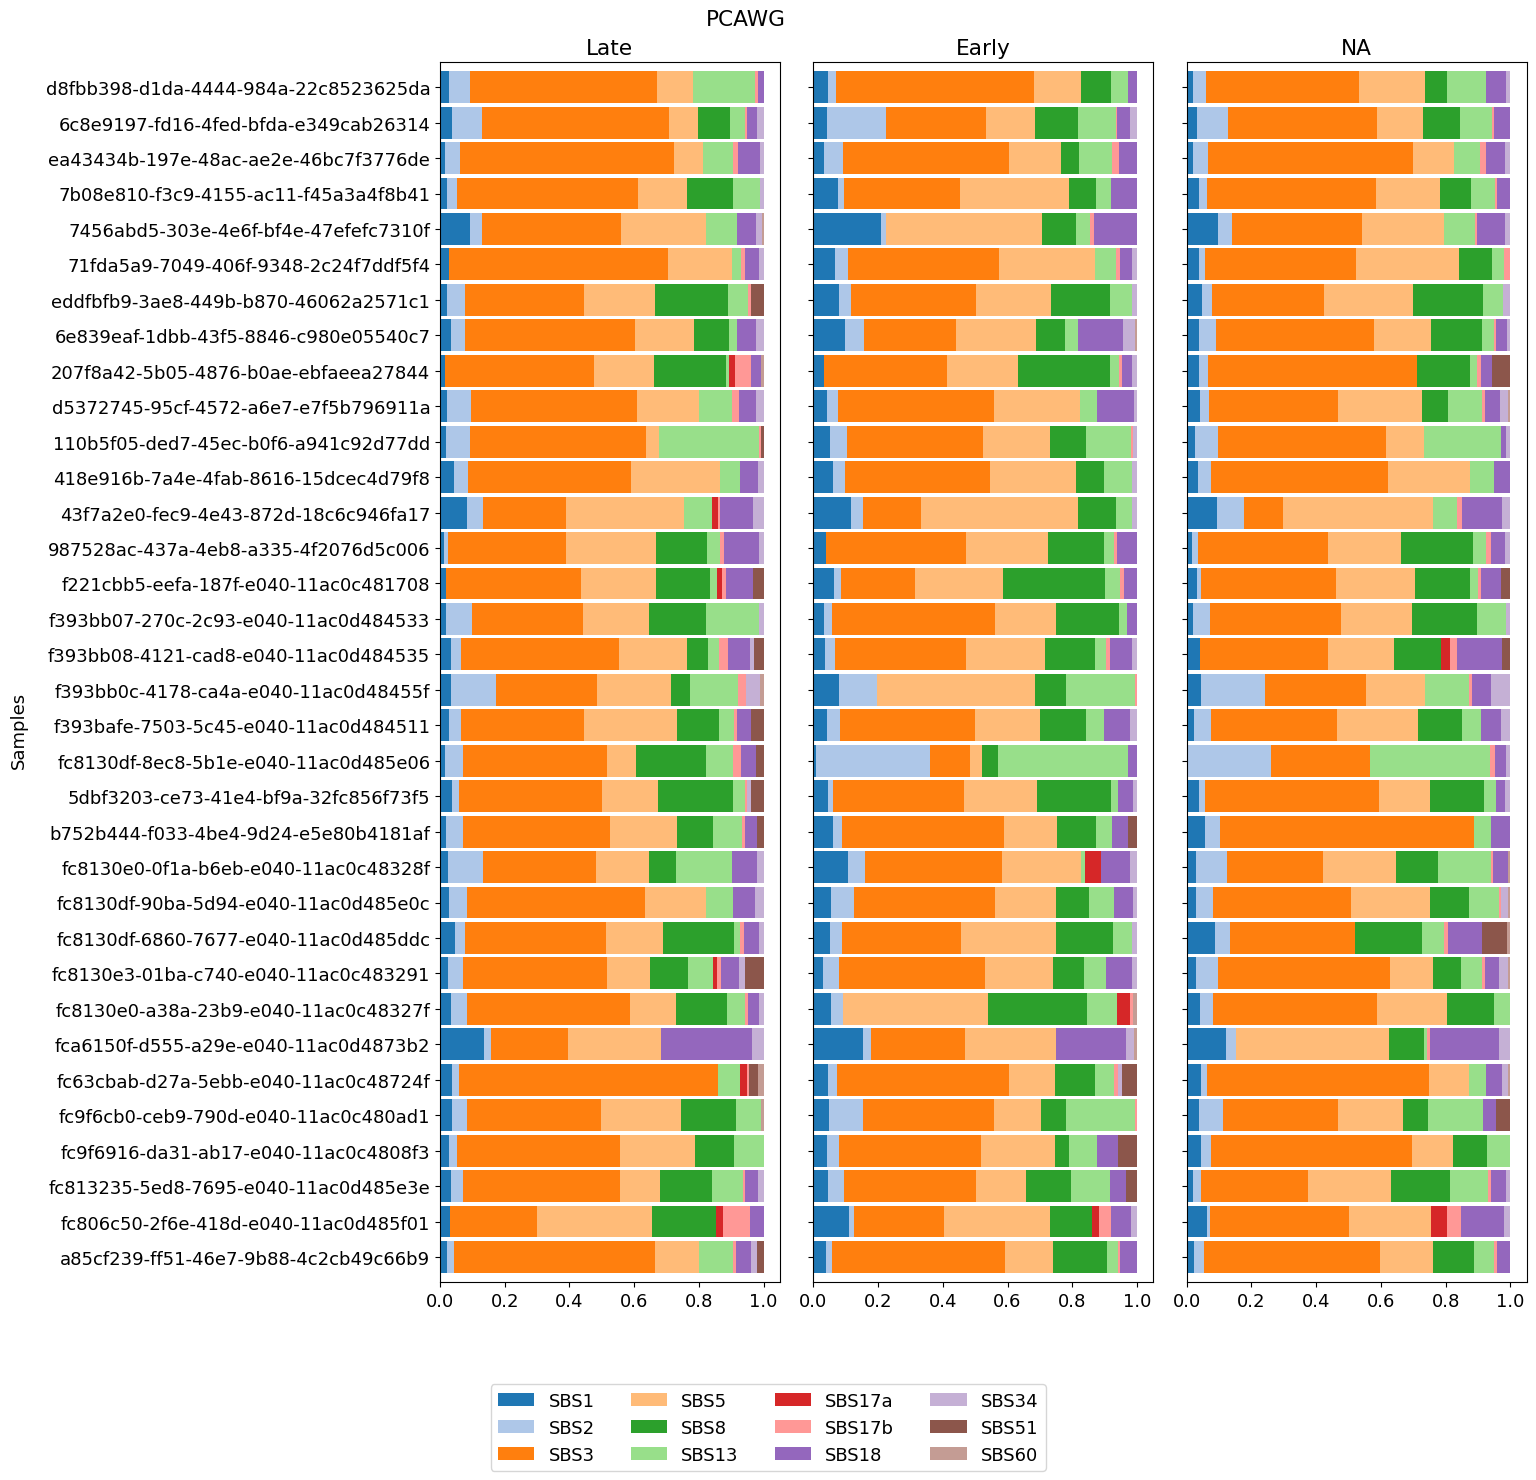

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



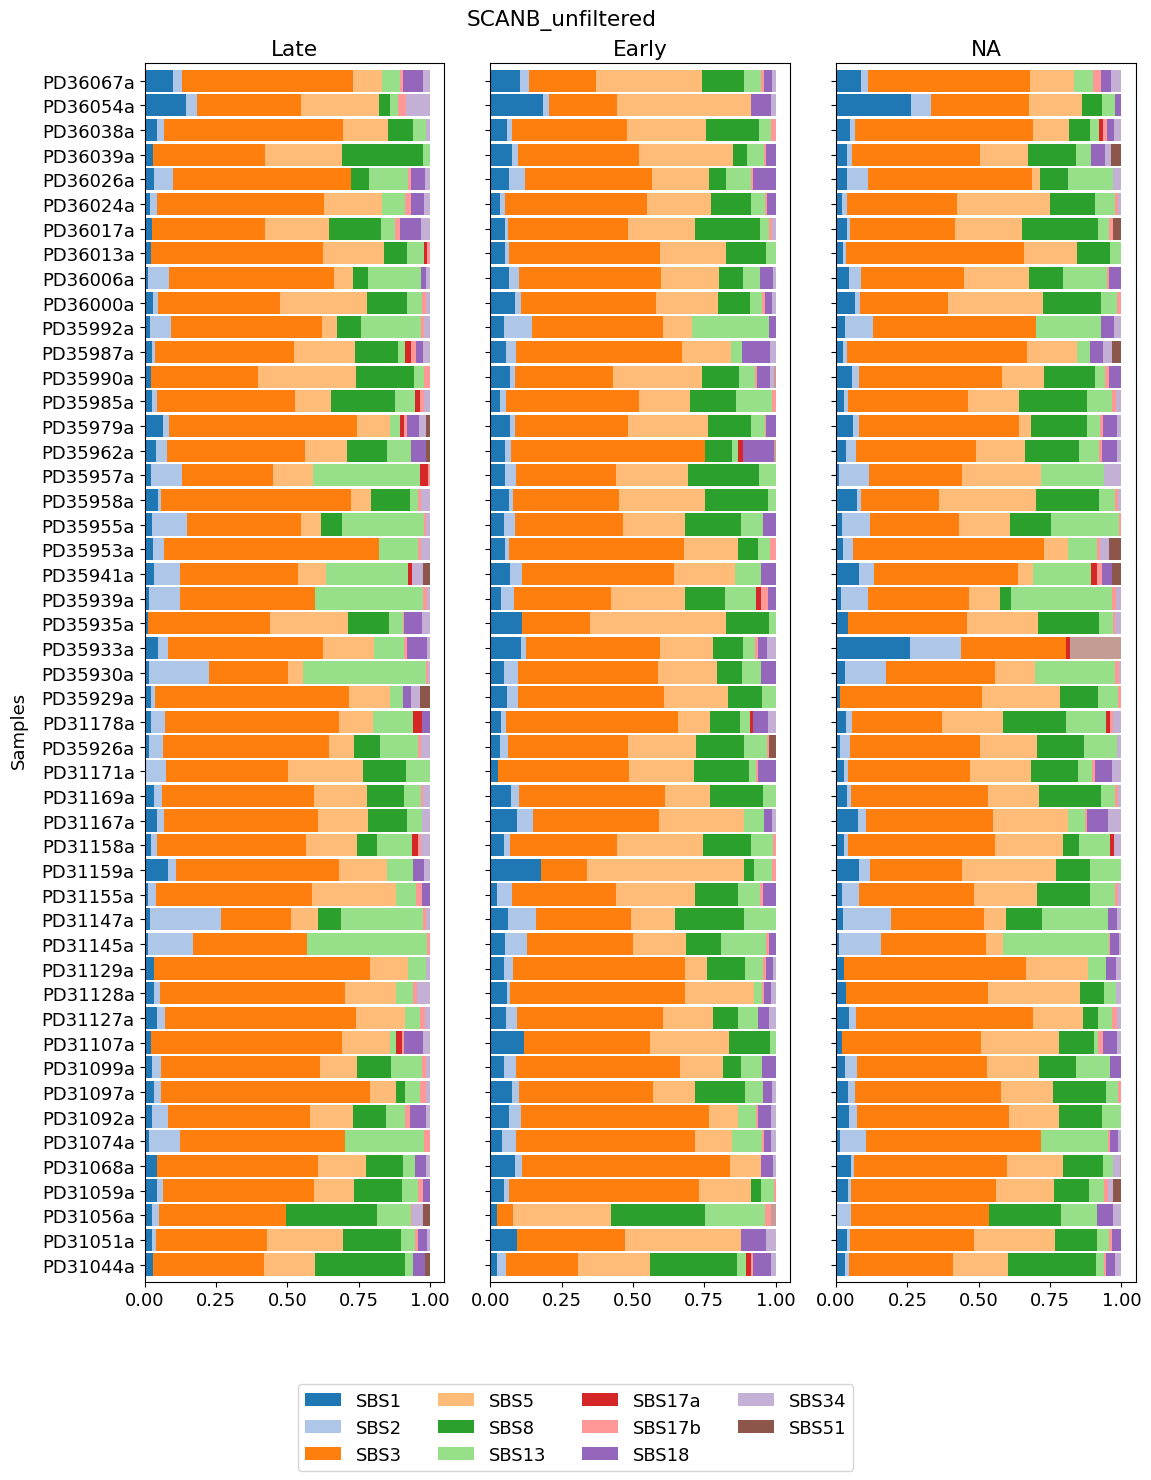

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

/var/folders/s2/3xsty6pj6cv1cjtsw14mt7fr0000gn/T/ipykernel_59924/1511215620.py:18: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



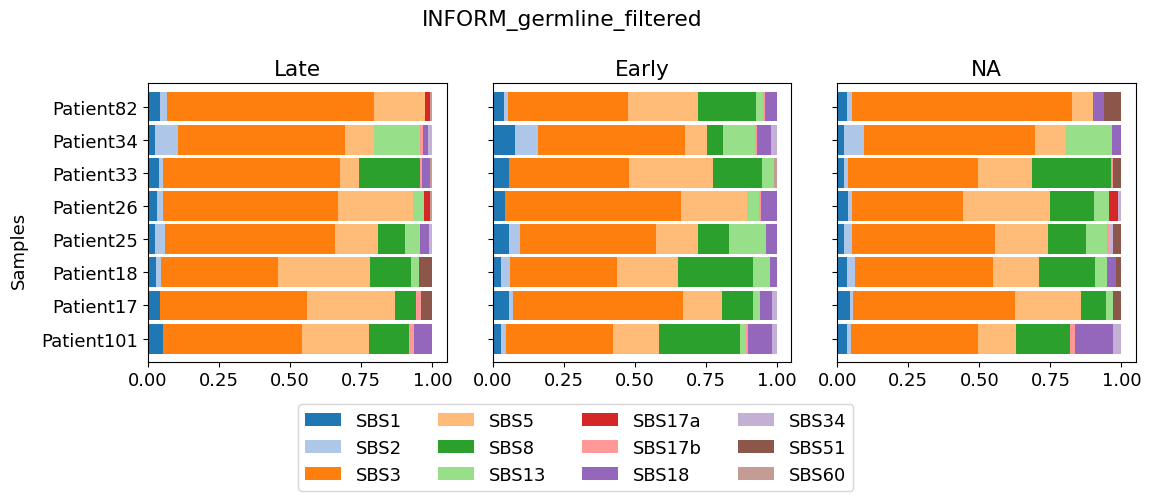

In [ ]:
# Create a color dict using an example file from one cohort
color_df = pd.read_csv(OUTPUT_INFORM + "/Breast/timing/SignatureFitting/Early/exposures/exposures_MuSiCal_lik.csv", index_col=0)
signatures = color_df.index.tolist()
colors = plt.cm.tab20.colors
signature_colors = {signature: colors[i % len(colors)] for i, signature in enumerate(signatures)}

def generate_plot(dataset_name, paths, indices, base_ids, timings, fig_size, signature_colors, legend_space = 0.1):
    # Read the dataset
    # Here I need to make an output folder to store all output HRD Files from all cohorts
    PCAWG_Breast_WGD_HRD = pd.read_csv(f"/Volumes/extSSD/park_lab/HRDTimer_Analysis/{dataset_name}_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")
    PCAWG_Breast_WGD_HRD_samples = PCAWG_Breast_WGD_HRD['ID']
    base_ids = PCAWG_Breast_WGD_HRD_samples
    indices = [[f"{i}_{t.lower()}" for i in base_ids] for t in timings]
    dfs = [pd.read_csv(p, index_col=0).T.loc[idx] for p, idx in zip(paths, indices)]

    # Apply index transformation for the dataset
    for df in dfs:
        df.index = df.index.str.split('_', 1).str[0]
        df = df[sorted(df.columns)]  # Sort columns to ensure consistent color mapping

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=fig_size, sharey=True)
    titles = ['Late', 'Early', 'NA']
    for ax, df, title in zip(axes, dfs, titles):
        # Apply the signature_colors dictionary for each entry
        color_list = [signature_colors.get(entry, 'gray') for entry in df.columns]
        df.plot(kind='barh', stacked=True, color=color_list, width=0.9, ax=ax, legend=False, title=title)

    # Add the legend and layout adjustments
    h, l = axes[0].get_legend_handles_labels()
    fig.legend(h, l, loc='lower center', ncol=4)
    fig.text(0.04, 0.5, 'Samples', va='center', rotation='vertical')
    plt.suptitle(dataset_name)
    plt.tight_layout(rect=[0.05, legend_space, 1, 1])

    # Save the plot with a filename based on the dataset name
    plt.savefig(f"AAA_Apr25_plots/{dataset_name}_Breast_WGD_HRD_SignatureFit.pdf", format='pdf', bbox_inches='tight')
    plt.show()

timings = ['Late', 'Early', 'NA']

# PCAWG
paths_pca = [OUTPUT_PCAWG + f"/Breast/timing/SignatureFitting/{t}/exposures/exposures_MuSiCal_lik_reduced_norm.csv" for t in timings]
generate_plot("PCAWG", paths_pca, None, None, timings, (16, 15), signature_colors)

# SCANB
paths_scanb = [OUTPUT_SCANB + f"/Breast/timing/SignatureFitting/{t}/exposures/exposures_MuSiCal_lik_reduced_norm.csv" for t in timings]
generate_plot("SCANB_unfiltered", paths_scanb, None, None, timings, (12, 15), signature_colors)

# INFORM
paths_inform = [OUTPUT_INFORM + f"/Breast/timing/SignatureFitting/{t}/exposures/exposures_MuSiCal_lik_reduced_norm.csv" for t in timings]
generate_plot("INFORM_germline_filtered", paths_inform, None, None, timings, (12, 5), signature_colors, legend_space=0.18)


# Compare WGDTime (SBS1 and CpG) across three datasets breast

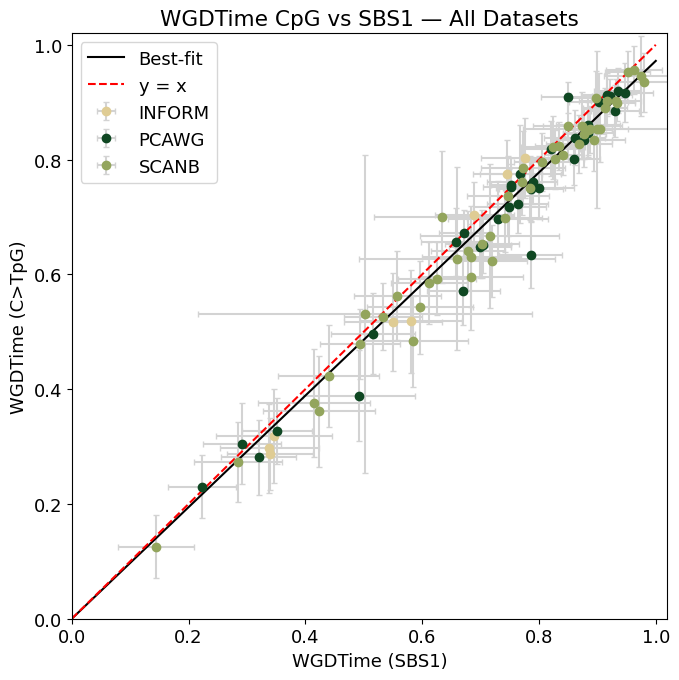

In [ ]:
files = {
    'SCANB': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv",
    'PCAWG': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001.csv",
    'INFORM': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv"
}

# Updated files according to the May27 run

files ={
    'SCANB': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv",
    'PCAWG': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv",
    'INFORM': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv"
}

df_all = pd.concat([
    pd.read_csv(f)[['WGDTime', 'WGDTime_ci', 'WGDTime_CpG', 'WGDTime_CpG_err']].assign(Dataset=k)
    for k, f in files.items()
]).dropna()

data = odr.RealData(df_all["WGDTime"], df_all["WGDTime_CpG"],
                    sx=df_all["WGDTime_ci"], sy=df_all["WGDTime_CpG_err"])
output = odr.ODR(data, odr.Model(lambda B, x: B[0]*x), beta0=[1.]).run()
slope, chi2 = output.beta[0], output.sum_square
#print(f"Slope: {slope:.3f}\nChi-squared: {chi2:.3f}\nReduced Chi-squared: {chi2/(len(df_all)-1):.3f}")

plt.figure(figsize=(7, 7))
colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}
for k, g in df_all.groupby("Dataset"):
    plt.errorbar(g["WGDTime"], g["WGDTime_CpG"], xerr=g["WGDTime_ci"], yerr=g["WGDTime_CpG_err"],
                 fmt='o', label=k, color=colors[k], ecolor='lightgrey', capsize=2)

x = np.linspace(0, 1, 100)
plt.plot(x, slope*x, 'k-', label='Best-fit')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlabel("WGDTime (SBS1)")
plt.ylabel("WGDTime (C>TpG)")
plt.title("WGDTime CpG vs SBS1 — All Datasets")
plt.xlim(0, 1.02), plt.ylim(0, 1.02)
plt.legend(), plt.tight_layout()
#plt.savefig("AAA_Apr25_plots/All_Cohorts_CpG_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


# Compare pi2 across all datasets

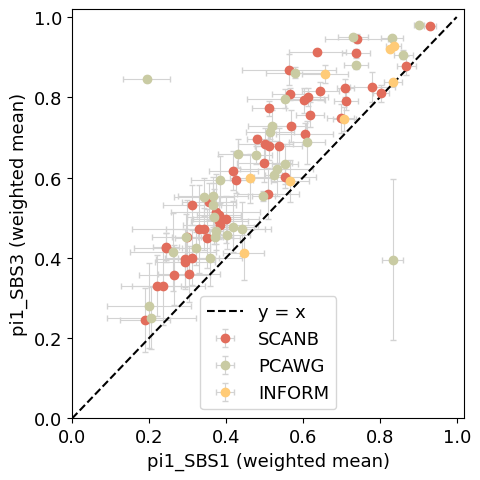

In [ ]:
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

def weighted_mean_std(values, weights):
    values, weights = np.array(values), np.array(weights)
    mask = ~np.isnan(values)
    values, weights = values[mask], weights[mask]
    if len(values) == 0: return np.nan, np.nan
    mean = np.sum(values * weights) / np.sum(weights)
    var = np.sum((values - mean)**2 * weights) / np.sum(weights)
    return mean, np.sqrt(var / len(values))

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'N_mut_all']).iterrows():
        w = parse_list(row['N_mut_all'])
        m1, e1 = weighted_mean_std(parse_list(row['pi1SBS1']), w)
        m3, e3 = weighted_mean_std(parse_list(row['pi1SBS3']), w)
        records.append({'Dataset': label, 'SBS1': m1, 'SBS1_err': e1, 'SBS3': m3, 'SBS3_err': e3})

plot_df = pd.DataFrame(records)

colors = {'SCANB': '#e26d5c', 'PCAWG': '#c9cba3','INFORM': '#ffcb77'}
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}
plt.figure(figsize=(5,5))
for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.errorbar(sub['SBS1'], sub['SBS3'], xerr=sub['SBS1_err'], yerr=sub['SBS3_err'],
                 fmt='o', label=d, color=colors[d], ecolor='lightgrey', capsize=2, markersize=6, elinewidth=0.8)

x = np.linspace(0, 1, 100)
plt.plot(x, x, 'k--', label='y = x')
plt.xlabel("pi1_SBS1 (weighted mean)")
plt.ylabel("pi1_SBS3 (weighted mean)")
plt.xlim(0, 1.02), plt.ylim(0, 1.02)
plt.legend(), plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/All_Cohorts_pi1SBS3_vs_pi1SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()

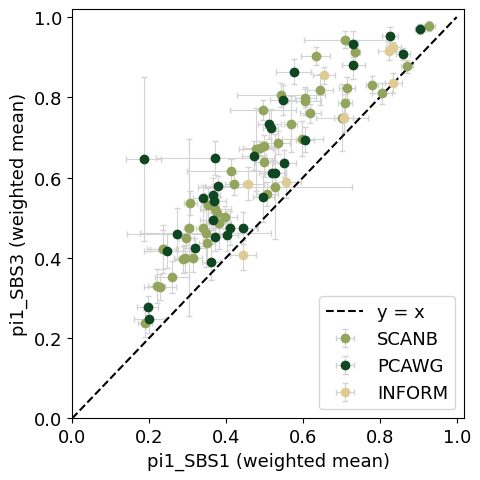

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Updated files according to the May27 run

files ={
    'SCANB': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv",
    'PCAWG': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv",
    'INFORM': "/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv"
}

outlier_samples = ['fca6150f-d555-a29e-e040-11ac0d4873b2',
                   '43f7a2e0-fec9-4e43-872d-18c6c946fa17',
                   'PD31056a']

def parse_list(s):
    return np.array(eval(s, {"nan": np.nan}), dtype=float)

def weighted_mean_and_propagated_error(values, errors, weights):
    values, errors, weights = map(np.array, (values, errors, weights))
    mask = ~np.isnan(values)
    values, errors, weights = values[mask], errors[mask], weights[mask]
    if len(values) == 0:
        return np.nan, np.nan
    mean = np.average(values, weights=weights)
    # Propagated error formula
    propagated_error = np.sqrt(np.sum((weights * errors) ** 2) / np.sum(weights) ** 2)
    return mean, propagated_error

# In the updated run the CIs for pi are the 95% confidence intervals (using the correct error here
# by propagating the individual pi errors)

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'pi1SBS1_ci', 'pi1SBS3_ci', 'N_mut_all']).iterrows():
        if row['ID'] in outlier_samples:
            continue  # Skip this sample
        w = parse_list(row['N_mut_all'])
        m1, e1 = weighted_mean_and_propagated_error(parse_list(row['pi1SBS1']), parse_list(row['pi1SBS1_ci']), w)
        m3, e3 = weighted_mean_and_propagated_error(parse_list(row['pi1SBS3']), parse_list(row['pi1SBS3_ci']), w)
        records.append({'Dataset': label, 'SBS1': m1, 'SBS1_err': e1, 'SBS3': m3, 'SBS3_err': e3})

plot_df = pd.DataFrame(records)

# Optional color scheme
colors = {'INFORM': '#DFCC94', 'SCANB': '#93A55D', 'PCAWG': '#0F4722'}

plt.figure(figsize=(5,5))
for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.errorbar(sub['SBS1'], sub['SBS3'], xerr=sub['SBS1_err'], yerr=sub['SBS3_err'],
                 fmt='o', label=d, color=colors[d], ecolor='lightgrey', capsize=2, markersize=6, elinewidth=0.8)

x = np.linspace(0, 1, 100)
plt.plot(x, x, 'k--', label='y = x')
plt.xlabel("pi1_SBS1 (weighted mean)")
plt.ylabel("pi1_SBS3 (weighted mean)")
plt.xlim(0, 1.02), plt.ylim(0, 1.02)
plt.legend(), plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/All_Cohorts_pi1SBS3_vs_pi1SBS1_May28.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

def weighted_mean_std(values, weights):
    values, weights = np.array(values), np.array(weights)
    mask = ~np.isnan(values)
    values, weights = values[mask], weights[mask]
    if len(values) == 0: return np.nan, np.nan
    mean = np.sum(values * weights) / np.sum(weights)
    var = np.sum((values - mean)**2 * weights) / np.sum(weights)
    return mean, np.sqrt(var / len(values))

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'N_mut_all']).iterrows():
        w = parse_list(row['N_mut_all'])
        m1, e1 = weighted_mean_std(parse_list(row['pi1SBS1']), w)
        m3, e3 = weighted_mean_std(parse_list(row['pi1SBS3']), w)
        records.append({
            'Dataset': label,
            'SBS1': m1, 'SBS1_err': e1,
            'SBS3': m3, 'SBS3_err': e3,
            'ID': row['ID'] if 'ID' in row else None
        })

df_plot = pd.DataFrame(records)

fig = go.Figure()

colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}
colors = {'SCANB': '#e26d5c', 'PCAWG': '#c9cba3','INFORM': '#ffcb77'}

for d in df_plot['Dataset'].unique():
    sub = df_plot[df_plot['Dataset'] == d]
    fig.add_trace(go.Scatter(
        x=sub['SBS1'], y=sub['SBS3'],
        error_x=dict(type='data', array=sub['SBS1_err'], visible=True),
        error_y=dict(type='data', array=sub['SBS3_err'], visible=True),
        mode='markers',
        name=d,
        marker=dict(color=colors[d]),
        text=sub['ID'],  # hover shows sample ID
        hovertemplate="ID: %{text}<br>SBS1: %{x:.3f} ± %{error_x.array:.3f}<br>SBS3: %{y:.3f} ± %{error_y.array:.3f}<extra></extra>"
    ))

fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='red'),
    name='y = x'
))

fig.update_layout(
    title="pi1SBS3 vs pi1SBS1 (weighted mean)",
    xaxis_title="pi1_SBS1 (weighted mean)",
    yaxis_title="pi1_SBS3 (weighted mean)",
    width=700, height=700,
    xaxis=dict(range=[0, 1.02]),
    yaxis=dict(range=[0, 1.02]),
    legend_title="Dataset"
)

fig.show()

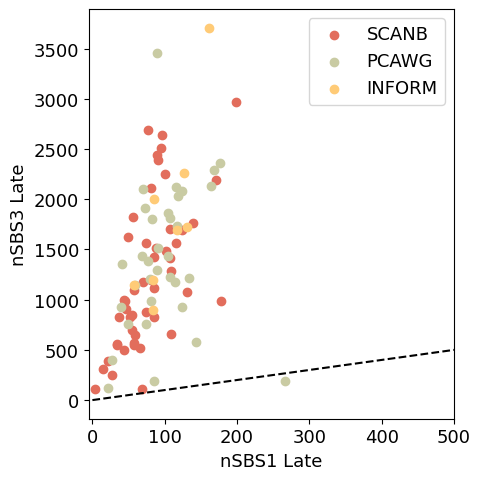

In [5]:
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'Nt_SBS1', 'Nt_SBS3']).iterrows():
        pi1_sbs1 = parse_list(row['pi1SBS1'])
        pi1_sbs3 = parse_list(row['pi1SBS3'])
        nt_sbs1 = parse_list(row['Nt_SBS1'])
        nt_sbs3 = parse_list(row['Nt_SBS3'])

        # Ignore np.nan when computing element-wise product and sum
        sbs1_mask = ~np.isnan(pi1_sbs1) & ~np.isnan(nt_sbs1)
        sbs3_mask = ~np.isnan(pi1_sbs3) & ~np.isnan(nt_sbs3)

        sbs1_total = np.sum(pi1_sbs1[sbs1_mask] * nt_sbs1[sbs1_mask])
        sbs3_total = np.sum(pi1_sbs3[sbs3_mask] * nt_sbs3[sbs3_mask])

        records.append({
            'Dataset': label,
            'SBS1_total': sbs1_total,
            'SBS3_total': sbs3_total
        })
        
plot_df = pd.DataFrame(records)

# Plotting
plt.figure(figsize=(5, 5))
colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}
colors = {'SCANB': '#e26d5c', 'PCAWG': '#c9cba3','INFORM': '#ffcb77'}

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['SBS1_total'], sub['SBS3_total'], label=d, color=colors[d], alpha=1)

plt.xlim(-5,500)
plt.plot([0,500], [0,500], 'k--')
plt.xlabel("nSBS1 Late")
plt.ylabel("nSBS3 Late")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/All_Cohorts_Late_SBS3_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


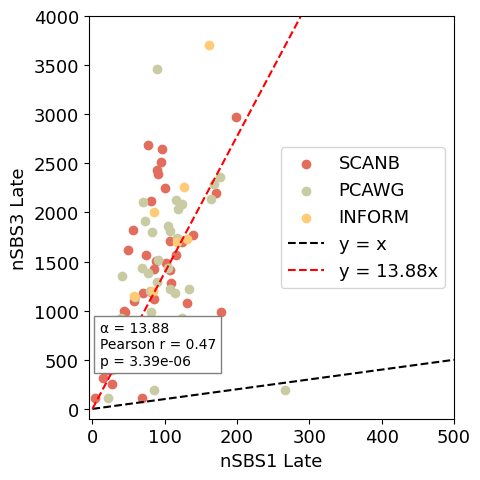

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Parse and compute as before
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['pi1SBS1', 'pi1SBS3', 'Nt_SBS1', 'Nt_SBS3']).iterrows():
        pi1_sbs1 = parse_list(row['pi1SBS1'])
        pi1_sbs3 = parse_list(row['pi1SBS3'])
        nt_sbs1 = parse_list(row['Nt_SBS1'])
        nt_sbs3 = parse_list(row['Nt_SBS3'])

        sbs1_mask = ~np.isnan(pi1_sbs1) & ~np.isnan(nt_sbs1)
        sbs3_mask = ~np.isnan(pi1_sbs3) & ~np.isnan(nt_sbs3)

        sbs1_total = np.sum(pi1_sbs1[sbs1_mask] * nt_sbs1[sbs1_mask])
        sbs3_total = np.sum(pi1_sbs3[sbs3_mask] * nt_sbs3[sbs3_mask])

        records.append({
            'Dataset': label,
            'SBS1_total': sbs1_total,
            'SBS3_total': sbs3_total
        })

plot_df = pd.DataFrame(records)

# Fit y = αx (no intercept)
x = plot_df['SBS1_total'].values
y = plot_df['SBS3_total'].values
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Force through origin fit: minimize sum of squared residuals
alpha = np.sum(x * y) / np.sum(x ** 2)  # slope (α)
fitted_y = alpha * x

# Pearson correlation and p-value
corr, pval = stats.pearsonr(x, y)

# Plot
plt.figure(figsize=(5, 5))
colors = {'SCANB': '#e26d5c', 'PCAWG': '#c9cba3','INFORM': '#ffcb77'}

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['SBS1_total'], sub['SBS3_total'], label=d, color=colors[d], alpha=1)

plt.plot([0, 500], [0, 500], 'k--', label='y = x')
plt.plot([0, 500], [0, alpha * 500], 'r--', label=f'y = {alpha:.2f}x')

plt.text(10, 450, f"α = {alpha:.2f}\nPearson r = {corr:.2f}\np = {pval:.2e}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))

plt.ylim(-100,4000)
plt.xlim(-5,500)
plt.xlabel("nSBS1 Late")
plt.ylabel("nSBS3 Late")
plt.legend()
plt.tight_layout()
#plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/All_Cohorts_Late_SBS3_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [6]:
x

array([ 54.70034785, 170.67264165,   3.16913671, 138.48244495,
       108.36519331,  77.30480479,  52.30840301, 107.14867315,
        57.01301312,  80.4075543 , 198.68477356,  84.95376688,
        43.73019856,  89.40640371,  43.46485671,  36.84762512,
       177.90013704,  74.5059297 ,  84.97638138, 115.29696037,
        14.84845159,  56.35299196,  22.04725541,  48.6353023 ,
        54.77570011,  59.55436432,  81.16971576,  95.07793504,
        26.72419226,  90.57901038, 102.35325239,  66.18279589,
        34.57002158,  85.4534447 ,  56.84680053,  87.27126255,
        57.19583409, 101.01728346,  45.82235412, 130.31968735,
        33.56543864,  95.73974396,  74.68488527,  44.9563551 ,
        70.50093996, 107.88546952, 123.6478429 ,  68.72850778,
       108.84961623,  73.07877359, 123.2404855 ,  89.46617899,
       124.35151935,  74.70906127, 115.57879083, 266.83632297,
       176.62459722,  76.83036473, 134.07058078, 107.35960379,
        80.81801583,  49.51920067, 164.05106889,  40.28

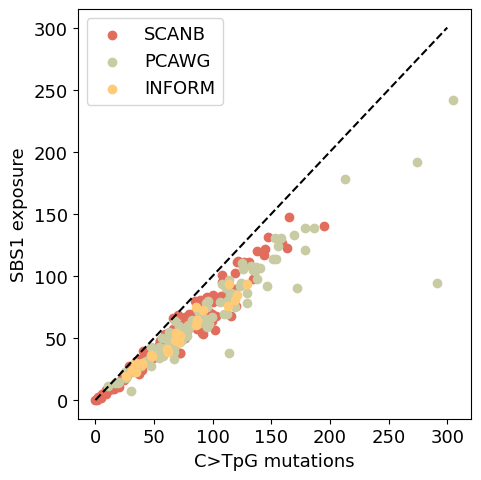

In [6]:
def parse_list(s): return np.array(eval(s, {"nan": np.nan}), dtype=float)

records = []
for label, f in files.items():
    df = pd.read_csv(f)
    for _, row in df.dropna(subset=['Nt_SBS1', 'N_mut(C>TpG)']).iterrows():
        nt_sbs1 = parse_list(row['Nt_SBS1'])
        ctpG = parse_list(row['N_mut(C>TpG)'])

        for x, y in zip(nt_sbs1, ctpG):
            records.append({
                'Dataset': label,
                'Nt_SBS1': x,
                'N_mut(C>TpG)': y
            })

plot_df = pd.DataFrame(records)

# Plotting
plt.figure(figsize=(5, 5))
colors = {'INFORM': '#3c1518', 'SCANB': '#71816d', 'PCAWG': '#e26d5c'}
colors = {'SCANB': '#e26d5c', 'PCAWG': '#c9cba3','INFORM': '#ffcb77'}

for d in plot_df['Dataset'].unique():
    sub = plot_df[plot_df['Dataset'] == d]
    plt.scatter(sub['N_mut(C>TpG)'],sub['Nt_SBS1'], label=d, color=colors[d], alpha=1)

plt.plot([0,300], [0,300], 'k--')
plt.ylabel("SBS1 exposure")
plt.xlabel("C>TpG mutations")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/All_cohorts_CpG_vs_SBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()

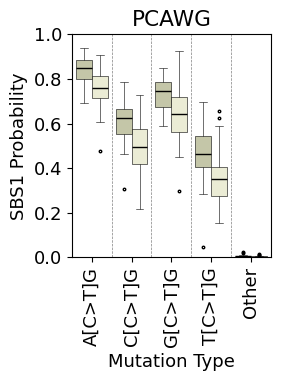

In [7]:
contexts = ['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G']
ids_to_include = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001.csv")['ID'].tolist()
early_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing/SignatureFitting/Early/probabilities/'
late_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_PCAWG_Apr25_v2/Breast/timing/SignatureFitting/Late/probabilities/'

def process_file(file_path, period):
    df = pd.read_csv(file_path, sep='\t')
    df_selected = df[df['MutationType'].isin(contexts)]
    df_selected.loc[:, 'Period'] = period
    df_other = df[~df['MutationType'].isin(contexts)]
    df_other.loc[:, 'MutationType'], df_other.loc[:, 'Period'] = 'Other', period
    other_mean = df_other['SBS1'].mean()
    df_other_mean = pd.DataFrame({'MutationType': ['Other'], 'SBS1': [other_mean], 'Period': [period], 'ID': ['Mean']})
    df_selected = pd.concat([df_selected, df_other_mean])
    file_name = os.path.basename(file_path)
    sample_id = file_name.split('_')[1]
    df_selected.loc[:, 'ID'] = sample_id
    return df_selected[['MutationType', 'SBS1', 'Period', 'ID']]

early_data = [process_file(os.path.join(early_dir, f), 'Early') for f in os.listdir(early_dir) if f.endswith('.txt')]
late_data = [process_file(os.path.join(late_dir, f), 'Late') for f in os.listdir(late_dir) if f.endswith('.txt')]

all_data = pd.concat(early_data + late_data)
filtered_data = all_data[all_data['ID'].isin(ids_to_include)]

plt.figure(figsize=(3, 4))
palette = {
    'Early': '#c9cba3',
    'Late': to_rgba('#eef0d1', alpha=0.1)  # Set alpha for 'Late' separately
}
sns.boxplot(x='MutationType', y='SBS1', hue='Period', data=filtered_data, palette=palette, fliersize=1.8,
            boxprops=dict(edgecolor='black', linewidth=0.4),
            whiskerprops=dict(color='black',  linewidth=0.4),
            capprops=dict(color='black', linewidth=0.4),
            medianprops=dict(color='black'),
            flierprops=dict(markeredgecolor='black', linewidth=0.5)
)

# Separate each context with a vertical dashed line
context_count = len(contexts) + 1  # Including the 'Other' context
for i in range(1, context_count):
    plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=.5)

plt.ylim(0, 1)
plt.title('PCAWG')
plt.xlabel('Mutation Type')
plt.ylabel('SBS1 Probability')
#plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.legend().set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_PCAWG_prob.pdf", format='pdf', bbox_inches='tight')
plt.show()


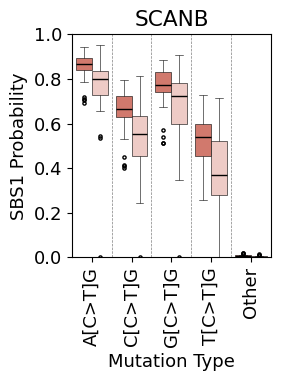

In [8]:
contexts = ['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G']
ids_to_include = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")['ID'].tolist()
early_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing/SignatureFitting/Early/probabilities/'
late_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_SCANB_unfiltered_Apr25/Breast/timing/SignatureFitting/Late/probabilities/'

def process_file(file_path, period):
    df = pd.read_csv(file_path, sep='\t')
    df_selected = df[df['MutationType'].isin(contexts)]
    df_selected.loc[:, 'Period'] = period
    df_other = df[~df['MutationType'].isin(contexts)]
    df_other.loc[:, 'MutationType'], df_other.loc[:, 'Period'] = 'Other', period
    other_mean = df_other['SBS1'].mean()
    df_other_mean = pd.DataFrame({'MutationType': ['Other'], 'SBS1': [other_mean], 'Period': [period], 'ID': ['Mean']})
    df_selected = pd.concat([df_selected, df_other_mean])
    file_name = os.path.basename(file_path)
    sample_id = file_name.split('_')[1]
    df_selected.loc[:, 'ID'] = sample_id
    return df_selected[['MutationType', 'SBS1', 'Period', 'ID']]

early_data = [process_file(os.path.join(early_dir, f), 'Early') for f in os.listdir(early_dir) if f.endswith('.txt')]
late_data = [process_file(os.path.join(late_dir, f), 'Late') for f in os.listdir(late_dir) if f.endswith('.txt')]

all_data = pd.concat(early_data + late_data)
filtered_data = all_data[all_data['ID'].isin(ids_to_include)]

plt.figure(figsize=(3, 4))
palette = {
    'Early': '#e26d5c',
    'Late': to_rgba('#f5c6bf', alpha=0.1)  # Set alpha for 'Late' separately
}
sns.boxplot(x='MutationType', y='SBS1', hue='Period', data=filtered_data, palette=palette, fliersize=2.3,
            boxprops=dict(edgecolor='black', linewidth=0.4),
            whiskerprops=dict(color='black',  linewidth=0.4),
            capprops=dict(color='black',  linewidth=0.4),
            medianprops=dict(color='black'),
            flierprops=dict(markeredgecolor='black', linewidth=0.2)
)

# Separate each context with a vertical dashed line
context_count = len(contexts) + 1  # Including the 'Other' context
for i in range(1, context_count):
    plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5)

plt.ylim(0, 1)
plt.title('SCANB')
plt.xlabel('Mutation Type')
plt.ylabel('SBS1 Probability')
plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.legend().set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_SCANB_prob.pdf", format='pdf', bbox_inches='tight')
plt.show()


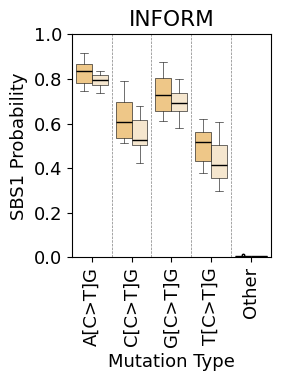

In [91]:
contexts = ['A[C>T]G', 'C[C>T]G', 'T[C>T]G', 'G[C>T]G']
ids_to_include = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")['ID'].tolist()
early_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing/SignatureFitting/Early/probabilities/'
late_dir = '/Volumes/extSSD/park_lab/HRDTimer_Analysis/AA_NEW_TEST_RUN_INFORM_germline_filtered_v2/Breast/timing/SignatureFitting/Late/probabilities/'

def process_file(file_path, period):
    df = pd.read_csv(file_path, sep='\t')
    df_selected = df[df['MutationType'].isin(contexts)]
    df_selected.loc[:, 'Period'] = period
    df_other = df[~df['MutationType'].isin(contexts)]
    df_other.loc[:, 'MutationType'], df_other.loc[:, 'Period'] = 'Other', period
    other_mean = df_other['SBS1'].mean()
    df_other_mean = pd.DataFrame({'MutationType': ['Other'], 'SBS1': [other_mean], 'Period': [period], 'ID': ['Mean']})
    df_selected = pd.concat([df_selected, df_other_mean])
    file_name = os.path.basename(file_path)
    sample_id = file_name.split('_')[1]
    df_selected.loc[:, 'ID'] = sample_id
    return df_selected[['MutationType', 'SBS1', 'Period', 'ID']]

early_data = [process_file(os.path.join(early_dir, f), 'Early') for f in os.listdir(early_dir) if f.endswith('.txt')]
late_data = [process_file(os.path.join(late_dir, f), 'Late') for f in os.listdir(late_dir) if f.endswith('.txt')]

all_data = pd.concat(early_data + late_data)
filtered_data = all_data[all_data['ID'].isin(ids_to_include)]

plt.figure(figsize=(3, 4))
palette = {
    'Early': '#ffcb77',
    'Late': to_rgba('#fce7c7', alpha=0.1)  # Set alpha for 'Late' separately
}
sns.boxplot(x='MutationType', y='SBS1', hue='Period', data=filtered_data, palette=palette, fliersize=1.8,
            boxprops=dict(edgecolor='black', linewidth=0.4),
            whiskerprops=dict(color='black', linewidth=0.4),
            capprops=dict(color='black', linewidth=0.4),
            medianprops=dict(color='black'),
            flierprops=dict(markeredgecolor='black', linewidth=0.5)
)
# Separate each context with a vertical dashed line
context_count = len(contexts) + 1  # Including the 'Other' context
for i in range(1, context_count):
    plt.axvline(x=i - 0.5, color='grey', linestyle='--', linewidth=0.5)

plt.ylim(0, 1)
plt.title('INFORM')
plt.xlabel('Mutation Type')
plt.ylabel('SBS1 Probability')
plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.legend().set_visible(False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/SBS1_INFORM_prob.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [3]:
import pandas as pd
import numpy as np

# Load the data
test_df = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot.csv")

# Convert string representations of lists into actual lists (if necessary)
test_df['pi1SBS1'] = test_df['pi1SBS1'].apply(eval)
test_df['pi1SBS1_ci'] = test_df['pi1SBS1_ci'].apply(eval)
test_df['N_mut_all'] = test_df['N_mut_all'].apply(eval)

# Function to compute weighted mean and propagated error
def weighted_mean_and_error(values, errors, weights):
    values = np.array(values)
    errors = np.array(errors)
    weights = np.array(weights)
    
    weighted_mean = np.average(values, weights=weights)
    
    # Propagated error for weighted mean
    weighted_variance = np.sum((weights * errors) ** 2) / np.sum(weights) ** 2
    weighted_error = np.sqrt(weighted_variance)
    
    return pd.Series([weighted_mean, weighted_error])

# Apply the function row-wise
test_df[['pi1SBS1_weighted_mean', 'pi1SBS1_weighted_error']] = test_df.apply(
    lambda row: weighted_mean_and_error(row['pi1SBS1'], row['pi1SBS1_ci'], row['N_mut_all']), axis=1
)

# View result
print(test_df[['pi1SBS1_weighted_mean', 'pi1SBS1_weighted_error']].head())



   pi1SBS1_weighted_mean  pi1SBS1_weighted_error
0               0.444338                0.020126
1               0.705977                0.013083
2               0.557173                0.025875
3               0.835645                0.009905
4               0.835091                0.011602
